In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Subset, DataLoader, WeightedRandomSampler, random_split
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np 
from finetuning_cnn import FineTuningCNN

Per il fine-tuting del modello ResNet18 e per migliorarne le prestazioni è stata scelta l'applicazione di diverse tecniche:

1. Uso di **WeightedRandomSampler** per risolvere lo squilibrio delle classi
Un WeightedRandomSampler può bilanciare i batch di training assegnando un peso maggiore alle classi minoritarie.

2. Aumento del Dataset con Data **Augmentation**
Migliorare la robustezza del modello applicando trasformazioni come rotazioni, zoom, cambi di colore, ecc., utilizzando trasformazioni maggiori per il training rispetto alle trasformazioni sui dati destinati alla validation

In [2]:
# Trasformazioni per il dataset
transform_training = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop((128, 128), scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


transform_validation = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
# --- Dataset base (senza transform) ---
dataset = ImageFolder(root='data')  # nessuna transform qui

# --- Carica lo split ---
split = torch.load('splits/dataset_split.pth')
train_indices = split['train_indices']
val_indices = split['val_indices']

# --- Applica lo split ---
train_subset = Subset(dataset, train_indices)
val_subset = Subset(dataset, val_indices)

# --- Wrapper per applicare transform dinamicamente ---
class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        return self.transform(img), label

    def __len__(self):
        return len(self.subset)

# --- Applica le trasformazioni specifiche ---
train_dataset = TransformedSubset(train_subset, transform_training)
validation_dataset = TransformedSubset(val_subset, transform_validation)

Weight Random Sampler

In [4]:
train_indices = train_dataset.subset.indices  # Indici effettivi nel train_dataset
train_labels = [dataset.samples[idx][1] for idx in train_indices]

class_sample_count = torch.tensor([train_labels.count(c) for c in range(len(dataset.classes))])
weights = 1. / class_sample_count.float()

sample_weights = torch.tensor([weights[label] for label in train_labels])
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

In [5]:
# DataLoader per il training e il validation set
# DataLoader carica i dati in batch
train_loader = DataLoader(train_dataset,
                          batch_size=32, # Il modello riceve 32 immagini alla volta
                          sampler=sampler) # Viene usato un WeightedRandomSampler per bilanciare le classi durante il training.
val_loader = DataLoader(validation_dataset, 
                        batch_size=32, 
                        shuffle=False) # Nessun sampler qui: i dati vengono letti in ordine per la validazione

In [ ]:


# Creazione del dataset unico
# ImageFolder carica le immagini e presuppone siano organizzate in cartelle, ogni cartella è una classe
dataset = ImageFolder(root=data_dir, transform=transform_minor)

# Divisione in training (80%) e validation (20%)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, val_size])

# Applica trasformazioni diverse al validation dataset
validation_dataset.dataset.transform = transform_validation

train_indices = train_dataset.indices  # Indici effettivi nel train_dataset
train_labels = [dataset.samples[idx][1] for idx in train_indices]

class_sample_count = torch.tensor([train_labels.count(c) for c in range(len(dataset.classes))])
weights = 1. / class_sample_count.float()

sample_weights = torch.tensor([weights[label] for label in train_labels])
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)




3. Modifica della CNN
- aggiunta **layer dropout** con probabilità p=0.3 nei blocchi intermedi del modello
- Modifica del **fully connected layer** per adattarlo al numero delle classi:
    Creata una piccola sequenza che include:
    Una prima Linear Layer che riduce la dimensionalità a 512.
    Una ReLU per aggiungere non-linearità.
    Il dropout layer per regolarizzare.
    L'ultimo Linear Layer che produce le previsioni finali per il numero delle classi.

4. Modifica del **learning rate** di Adam Optimizer perchè un learning rate troppo alto o troppo basso può impedire al modello di convergere.

5. Aggiunta di **Early Stopping**
Quando la performance del validation set non migliora per un certo numero di epoche consecutive, interrompe il training anticipatamente per evitare overfitting.

6. Aggiunta di **Weight Decay**
Tecnica di regolarizzazione usata per prevenire l'overfitting. Aggiunge un termine di penalità proporzionale ai pesi del modello nella funzione di costo. Questo termine forza il modello a mantenere i pesi più piccoli possibile, riducendo la complessità e il rischio di sovra-adattamento ai dati di training.

In [7]:
# Number of classes
num_classes = len(dataset.classes)

In [8]:
# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_classes=num_classes).to(device)

c:\Users\Giuseppe\anaconda3\envs\bio_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Giuseppe\anaconda3\envs\bio_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Step 3: Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-4)

In [10]:
# Step 4: Train the Model
train_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 25
patience = 5  # Numero massimo di epoche senza miglioramento
early_stop_count = 0
best_val_accuracy = 0.0  # Per memorizzare la miglior validation accuracy

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # Validation Accuracy
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Stampa risultati
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracies[-1]:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

    # Early Stopping: Controlla il miglioramento della validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        early_stop_count = 0  # Resetta il contatore
        # Puoi anche salvare il modello migliore
        torch.save(model.state_dict(), 'best_model.pth')  # Salva il modello migliore
    else:
        early_stop_count += 1

    if early_stop_count >= patience:
        print("Early stopping triggered. Stopping training...")
        break


Epoch [1/25], Loss: 6.5319, Train Accuracy: 0.41%, Validation Accuracy: 0.00%
Epoch [2/25], Loss: 6.4777, Train Accuracy: 0.49%, Validation Accuracy: 0.00%
Epoch [3/25], Loss: 6.3122, Train Accuracy: 0.81%, Validation Accuracy: 0.00%
Epoch [4/25], Loss: 6.1373, Train Accuracy: 0.97%, Validation Accuracy: 0.65%
Epoch [5/25], Loss: 5.9143, Train Accuracy: 1.06%, Validation Accuracy: 0.00%


KeyboardInterrupt: 

In [20]:
torch.save(model.state_dict(), 'handwriting_model.pth')

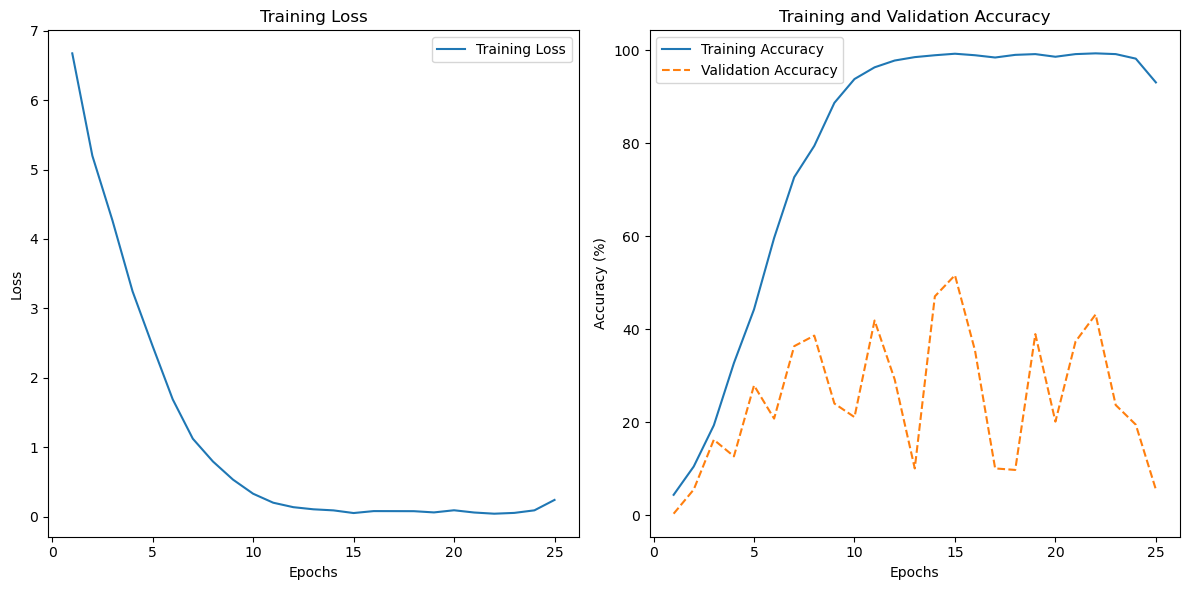

In [21]:
# Step 5: Plot Training and Validation Metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Split Dataset: Train/Test
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train, test = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [ ]:
# DataLoader
train_load = DataLoader(train, batch_size=32, shuffle=True)
test_load = DataLoader(test, batch_size=32, shuffle=False)

In [ ]:
def add_new_author(new_author_data_path, model, num_classes, train_loader, val_loader, epochs=10):
    """
    Function to add a new author to the handwriting identification system.

    Args:
        new_author_data_path (str): Path to the new author's data.
        model (torch.nn.Module): Pre-trained model.
        num_classes (int): Current number of classes in the model.
        train_loader (DataLoader): DataLoader for existing training data.
        val_loader (DataLoader): DataLoader for validation data.
        epochs (int): Number of fine-tuning epochs.

    Returns:
        torch.nn.Module: Fine-tuned model.
    """
    # Load new author's data
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    new_author_dataset = ImageFolder(root=new_author_data_path, transform=transform)
    new_author_loader = DataLoader(new_author_dataset, batch_size=32, shuffle=True)

    # Update the final layer of the model to include the new class
    model.fc = nn.Linear(model.fc.in_features, num_classes + 1)  # Add one more class
    model.to(device)

    # Optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Fine-tuning
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        # Train on both new author and existing data
        for images, labels in new_author_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(new_author_loader):.4f}")

    return model


In [ ]:
# Path to new author's data
new_author_data_path = "/path/to/new/author/data"

# Add new author to the system
model = add_new_author(
    new_author_data_path=new_author_data_path,
    model=model,
    num_classes=num_classes,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=10
)

# Salva il modello aggiornato
torch.save(model.state_dict(), 'handwriting_model_updated.pth')


In [ ]:
# Visualize correct predictions
model.eval()
correct_images, correct_labels, predicted_labels = [], [], []

with torch.no_grad():
    for images, labels in test_load:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        mask = (predicted == labels)
        correct_images.extend(images[mask].cpu())
        correct_labels.extend(labels[mask].cpu())
        predicted_labels.extend(predicted[mask].cpu())
        if len(correct_images) >= 10:  # Display 10 correct images
            break

# Visualize correct predictions
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    img = correct_images[i].permute(1, 2, 0)  # Convert from CxHxW to HxWxC
    img = img * 0.5 + 0.5  # Denormalize
    plt.imshow(img.numpy())
    plt.title(f"Label: {correct_labels[i].item()}\nPred: {predicted_labels[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()